In [1]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
from datetime import datetime

import helper_functions.utils
import helper_functions.flood_utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.dryRouting
import helper_functions.routing.floodedRouting
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.flood_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.dryRouting)
importlib.reload(helper_functions.routing.floodedRouting)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.flood_utils as flood_utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.dryRouting as dryRouting
import helper_functions.routing.floodedRouting as floodedRouting
import helper_functions.routing.publicTransit as publicTransit

# Import G

In [22]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))
# import planning area
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")


# Import historical floods

In [2]:
historical_floods = pd.read_csv(r"Flood_Weather_Data\precipitation_levels_during_flood_events.csv")
print(historical_floods.dtypes)
print("Length of df: ",len(historical_floods.index))
print("Number of unique flood events: ",len(historical_floods['matched_location'].unique()))
historical_floods.head()

flooded_location                  object
responses_found                    int64
matched_location                  object
latitude                         float64
longitude                        float64
closest_weather_stn               object
mean_pr                          float64
daily rainfall total (mm)        float64
highest 30 min rainfall (mm)     float64
highest 60 min rainfall (mm)     float64
highest 120 min rainfall (mm)    float64
drainage_catchment                object
time                              object
dtype: object
Length of df:  220
Number of unique flood events:  144


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16


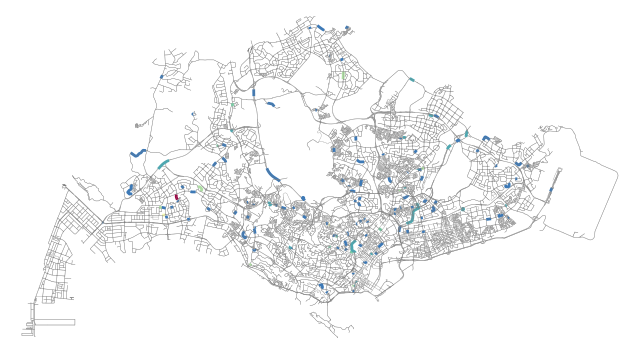

In [21]:
def plot_flooded_roads_frequency(G, historical_floods,cmap='plasma',ax=None):
    """ 
    Plot the frequency of flooded roads in the network graph G.
    Args:
        G (networkx.Graph): The network graph.
        historical_floods (pandas.DataFrame): DataFrame containing historical flood data.
    """
    # calculate the frequency of flooded roads based on matched_location
    flooded_roads_frequency = historical_floods[['matched_location','latitude','longitude']].value_counts().reset_index()
    
    # get unique colours based on unique max speed, colors start and end must be from 0 to 1
    max_freq = flooded_roads_frequency['count'].max()
    min_freq = flooded_roads_frequency['count'].min()
    iso_colors = ox.plot.get_colors(n=max_freq, cmap=cmap, start=min_freq/max_freq, stop=1)
    # add an additional column to flooded_roads_frequency for the color that matches the frequency
    flooded_roads_frequency['color'] = flooded_roads_frequency['count'].apply(lambda x: iso_colors[x-1])

    # get closest edges to the flooded roads
    flooded_edges = ox.distance.nearest_edges(G,X = flooded_roads_frequency['longitude'], Y = flooded_roads_frequency['latitude'])
    flooded_edges = list(flooded_edges)

    # get the flooded edges from the graph
    color_map = {e: color for color, e in zip(flooded_roads_frequency['color'], flooded_edges)}
    ec = [color_map[e] if e in flooded_edges else "grey" for e in G.edges(keys=True) ]
    ew = [2 if e in flooded_edges else 0.2 for e in G.edges(keys=True) ]
    fig, ax = ox.plot_graph(
        G,
        node_size=0,
        edge_color = ec,
        edge_linewidth=ew,
        ax=ax,
        bgcolor='white',
        show = False,
        close = False
    )
    
    # historical_floods[['matched_location','latitude','longitude']].groupby(['matched_location']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10)
    return

plot_flooded_roads_frequency(G_bus, historical_floods,cmap='Spectral_r')

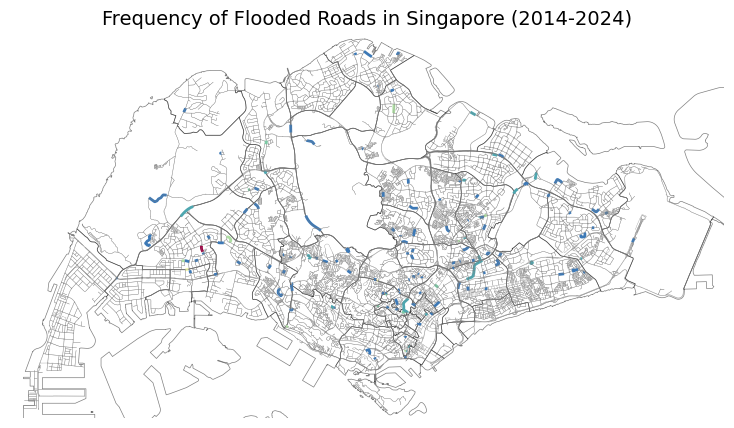

In [25]:
ax = planningArea_shp.plot(fc="none", ec="black", lw=0.5, alpha=0.5, figsize=(12, 5))
ax.set_title("Frequency of Flooded Roads in Singapore (2014-2024)", fontsize=14)
plot_flooded_roads_frequency(G_bus, historical_floods,cmap='Spectral_r',ax=ax)

# Aims and objectives
- to find out the capacity and flow of roads

### Import Roads meta data
- name
- coordinates for roads

In [3]:
SG_ROADS = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Roads\SG_Roads.csv")
print("length of SG_ROADS: ", len(SG_ROADS.index))
SG_ROADS.head()

length of SG_ROADS:  5201


,NAME,FOLDERPATH,SYMBOLID,INC_CRC,FMEL_UPD_D,Latitude,Longitude
0,UPPER THOMSON ROAD,Layers/Expressway_Sliproad,2,4204F69A3FC7CBC0,8/7/2021 0:00:00,1.394282,103.818891
1,UPPER THOMSON ROAD,Layers/Expressway_Sliproad,2,EA3CCC8B37AFFE28,8/7/2021 0:00:00,1.394321,103.818961
2,UPPER THOMSON ROAD,Layers/Expressway_Sliproad,2,B5B7DCFCC246C14F,8/7/2021 0:00:00,1.394429,103.819194
3,UPPER THOMSON ROAD,Layers/Expressway_Sliproad,2,0DF89AD1A0B6A65C,8/7/2021 0:00:00,1.394284,103.818561
4,UPPER THOMSON ROAD,Layers/Expressway_Sliproad,2,3D09F027B4BA5F8F,8/7/2021 0:00:00,1.394809,103.819043


<Axes: >

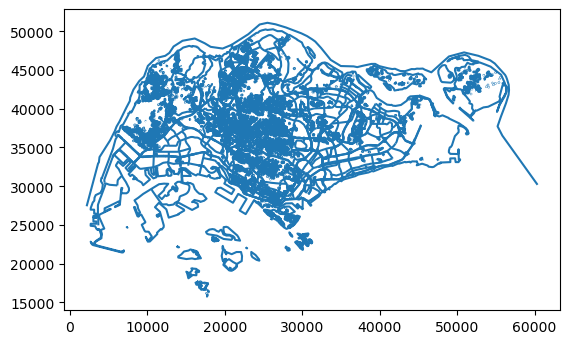

In [4]:
SG_ROADS_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Roads\SG_Roads.shp")
# plot the roads
SG_ROADS_shp.plot()

### Import traffic flow
- Returns hourly average traffic flow, taken from a representative month of  every quarter during 0700-0900 hours.
- CAT1 - Expressways
- CAT2 - Major arterials
- CAT3 - Minor arterials
- CAT4 - Primary accesses
- CAT5 - Local accesses
- Slip road - slip roads

See ANNEX F of LTA DataMall API userguide for more description

In [43]:
def get_max_traffic_flow(traffic_flow):
    """ 
    Args:
        traffic_flow (dict or str): if dict, it should be a dictionary loaded from a json file containing the traffic flow data.
                                     if str, it should be a path to a json file containing the traffic flow data.
    """
    if isinstance(traffic_flow, str):
        # load the json file
        traffic_flow = utils.load_json(traffic_flow)
        # convert the traffic flow data to a pandas dataframe
        traffic_flow = pd.DataFrame(traffic_flow['Value'])
    
    # remove NAs
    traffic_flow = traffic_flow[~(traffic_flow == '#N/A').any(axis=1)]
    # Convert columns to float, round to 7 decimals, then to string
    for col in ['StartLat', 'StartLon', 'EndLat', 'EndLon']:
        traffic_flow[col] = traffic_flow[col].astype(float).round(9).astype(str)
    # group by RoadName and get the maximum of the Volume column (car volume)
    max_traffic_flow = pd.DataFrame(traffic_flow.groupby(['RoadName','RoadCat','StartLat','StartLon','EndLat','EndLon'])[['Volume']].max()).reset_index()
    return max_traffic_flow

# load all the traffic flow data
traffic_flow_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\trafficflow"
traffic_flow_dfs = [os.path.join(traffic_flow_dir,fp) for fp in os.listdir(traffic_flow_dir) if fp.endswith('.json')]
traffic_flow_dfs = [utils.load_json(fp) for fp in traffic_flow_dfs]
traffic_flow_dfs = [pd.DataFrame(df['Value']) for df in traffic_flow_dfs]
# concatenate all the dataframes
traffic_flow = pd.concat(traffic_flow_dfs, ignore_index=True)
print("length of traffic flow: ", len(traffic_flow))
max_traffic_flow = get_max_traffic_flow(traffic_flow)
print("length of max traffic flow: ", len(max_traffic_flow))
# export the max traffic flow to a csv file
max_traffic_flow.to_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\trafficflow\max_traffic_flow.csv", index=False)
max_traffic_flow.sort_values('RoadName').head()

length of traffic flow:  368415


C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1066260454.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_flow[col] = traffic_flow[col].astype(float).round(9).astype(str)
C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1066260454.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_flow[col] = traffic_flow[col].astype(float).round(9).astype(str)
C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1066260454.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

length of max traffic flow:  1319


,RoadName,RoadCat,StartLat,StartLon,EndLat,EndLon,Volume
0,ADAM ROAD,CAT2,1.320198885,103.8115894,1.321445336,103.8127463,850
1,ADAM ROAD,CAT2,1.321445336,103.8127463,1.320198885,103.8115894,998
2,ADAM ROAD,CAT2,1.328006158,103.8139504,1.326595556,103.8138308,986
3,ADAM ROAD,CAT2,1.332484797,103.8164281,1.333639259,103.8171146,982
4,ADAM ROAD,CAT2,1.332912733,103.8151113,1.333314056,103.8142501,966


In [46]:
max_traffic_flow.sort_values('RoadCat', ascending=False).head(20)

,RoadName,RoadCat,StartLat,StartLon,EndLat,EndLon,Volume
1063,TAMPINES EXPRESSWAY,SLIP_ROAD,1.357508351,103.9626651,1.358322871,103.9620428,997
1011,TAMPINES AVENUE 7,SLIP_ROAD,1.361699734,103.9596204,1.362773001,103.9588099,994
1004,STILL ROAD SOUTH,SLIP_ROAD,1.300654588,103.9084665,1.300440869,103.9075516,984
1005,STILL ROAD SOUTH,SLIP_ROAD,1.302841041,103.9114384,1.302191371,103.9129629,97
339,EAST COAST PARK SERVICE ROAD,SLIP_ROAD,1.319997849,103.96856,1.31891439,103.9685065,99
338,EAST COAST PARK SERVICE ROAD,SLIP_ROAD,1.318250369,103.9668813,1.317783655,103.9651982,52
337,EAST COAST PARK SERVICE ROAD,SLIP_ROAD,1.3118352,103.9487044,1.311160396,103.9493806,99
336,EAST COAST PARK SERVICE ROAD,SLIP_ROAD,1.310129404,103.9402957,1.310455813,103.9397357,97
1007,TAMPINES AVENUE 10,SLIP_ROAD,1.37725178,103.9284068,1.376564409,103.9295391,993
1008,TAMPINES AVENUE 12,SLIP_ROAD,1.367282074,103.9446795,1.368524003,103.9438194,999


In [42]:
# traffic_flow_dfs[0].sort_values(by=['RoadName','StartLat','StartLon','EndLat','EndLon'])
# group by RoadName and get the standard deviation of the StartLat, StartLon, EndLat, EndLon columns
df = traffic_flow_dfs[0]
df = df[~(df == '#N/A').any(axis=1)]
# df.groupby('RoadName')[['StartLat','StartLon','EndLat','EndLon']].std()
# Convert columns to float, round to 7 decimals, then to string
for col in ['StartLat', 'StartLon', 'EndLat', 'EndLon']:
    df[col] = df[col].astype(float).round(9).astype(str)

df.sort_values(by='RoadName')

C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1211289210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float).round(9).astype(str)
C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1211289210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float).round(9).astype(str)
C:\Users\hypak\AppData\Local\Temp\ipykernel_50248\1211289210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,LinkID,Date,HourOfDate,Volume,StartLon,StartLat,EndLon,EndLat,RoadName,RoadCat
63118,06/02/2025,7,103109250,3501,103.8127463,1.321445336,103.8115894,1.320198885,ADAM ROAD,CAT2
46959,23/02/2025,8,103087827,1579,103.8139504,1.328006158,103.8138308,1.326595556,ADAM ROAD,CAT2
66235,26/02/2025,7,103087827,4198,103.8139504,1.328006158,103.8138308,1.326595556,ADAM ROAD,CAT2
62212,18/02/2025,7,103109250,3342,103.8127463,1.321445336,103.8115894,1.320198885,ADAM ROAD,CAT2
54673,14/02/2025,8,103109251,2237,103.8115894,1.320198885,103.8127463,1.321445336,ADAM ROAD,CAT2
...,...,...,...,...,...,...,...,...,...,...
27925,25/02/2025,7,104005966,869,103.7253372,1.326785267,103.7257685,1.325685535,YUAN CHING ROAD,CAT3
27924,06/02/2025,7,104005966,869,103.7253372,1.326785267,103.7257685,1.325685535,YUAN CHING ROAD,CAT3
2747,09/02/2025,8,103092839,182,103.72479,1.329388633,103.724811,1.330233155,YUAN CHING ROAD,CAT3
28093,26/02/2025,8,108003206,874,103.7250642,1.33515158,103.7250421,1.334246149,YUAN CHING ROAD,CAT3
